# How to Identify Flares Using Stella

In this notebook I will provide a step by step process of how to identify flares on a given star. We will start off by loading in the relevant data. From there you will be able to follow along with the stella tutorial. The final step of the project is to say something about the number of flares and the frequency of flare events on a given star. To do this we will be making a flare frequency diagram (FFD) using the list of flares provided by stella.

## Part 1: Loading in the data

In [2]:
import numpy

To start off we will be loading in the relevant python packages that we will be using for the project

In [2]:
%matplotlib inline                
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import lightkurve as lk               
import stella                    

Next, we will be using the package 'lighkurve' to load in the light curves of a given star

You can read more about the lightkurve package here: https://docs.lightkurve.org/index.html

In [3]:
star = lk.search_lightcurve('TIC140045538',exptime=120,author='spoc')

In [4]:
star

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,140045538,0.0
1,TESS Sector 28,2020,SPOC,120,140045538,0.0


This target was observed across many sectors and at various exposure times. 

Sector = TESS observes the sky in regions of 24x96 degrees for approximately 1 month at a time. Each of these regions is referred to as a "sector", starting with Sector 1.

Stella only like 2 minute data (120s) so we will use the first data product in the table

In [5]:
lc = star.download_all().PDCSAP_FLUX
#lc

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  """Entry point for launching an IPython kernel.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:162: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  return LightCurveCollection([lc.PDCSAP_FLUX for lc in self])


In [6]:
cd51lc = lc[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(lc)):
    try:
        cd51lc = cd51lc.append(lc[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  """Entry point for launching an IPython kernel.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  


Plotting the light curve 4 quarters of data

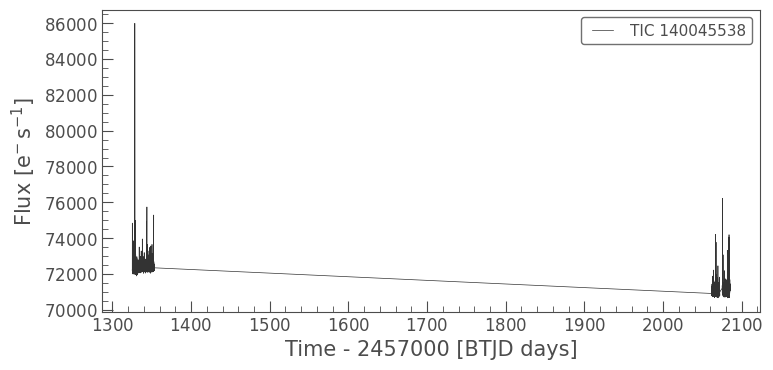

In [7]:
cd51lc.plot(); #this makes a plot of the light curve
#plt.xlim(1745,1750)
#plt.ylim(109000,115000)

#plt.savefig('/Users/lupitatovar/PreMAP2021/figures/EV_LAC.png')

A note on time units:

BJD = Barycentric Julian Date, the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System center of mass.


BTJD = Barycentric TESS Julian Date, the timestamp measured in BJD, but offset by 2457000.0. I.e., BTJD = BJD - 2457000.0

Normalizing the light curve

In [9]:
cd51lc.pdcsap_flux.value/np.nanmedian(cd51lc.pdcsap_flux.value)

array([1.0009829 , 1.0003413 , 1.0006083 , ..., 0.9855918 , 0.98463947,
       0.98617935], dtype=float32)

In [10]:
median_flux = cd51lc.pdcsap_flux.value/np.nanmedian(cd51lc.pdcsap_flux.value)-1


In [11]:
plt.rcParams['axes.linewidth']=1.5
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ['Verdana']

Text(0.5, 1.0, 'WT84')

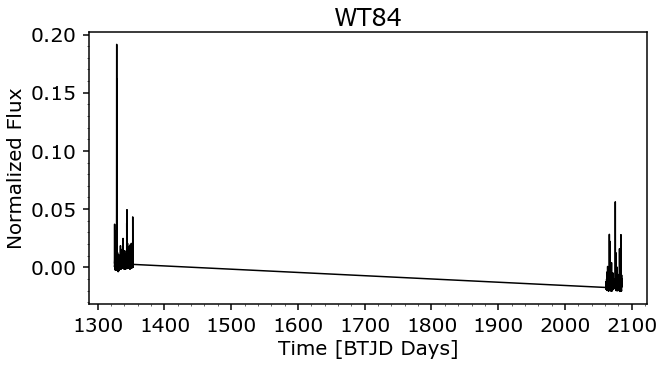

In [13]:
plt.figure(figsize=[10,5])
plt.minorticks_on()
plt.tick_params(direction='out',width=1.5,length=6,pad=7)
plt.plot(cd51lc.time.btjd,median_flux,color='k')
plt.xlabel('Time [BTJD Days]')
plt.ylabel('Normalized Flux')
plt.title('WT84')
#plt.xlim(1353,1382)
#plt.xlim(2060,2145)
#plt.ylim(-0.2,2)

We can use stella to calculate the rotation period of the star

In [14]:
target = '140045538' #I set a variable called target so I don't have to keep typing the star ID
P_rot = stella.MeasureProt([target], [cd51lc.time.btjd], [cd51lc.flux], [cd51lc.flux_err])

In [15]:
print(target)

140045538


Now that we have provided the target, flux, and time arrays stella can calculate the rotation period

In [16]:
P_rot.run_LS()

Finding most likely periods: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


In [17]:
P_rot.LS_results

Target_ID,period_days,secondary_period_days,gauss_width,max_power,secondary_max_power,orbit_flag,oflag1,oflag2,Flags,avg_period_days
str9,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
140045538,1.1246682977638514,1.1242766898230754,0.0171546130435212,0.17203886949554653,0.034885934696725344,0.0,0.0,0.0,0,1.1246682977638514


This star has a rotation period of 4.2 days, we can fold the light curve using the average period

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

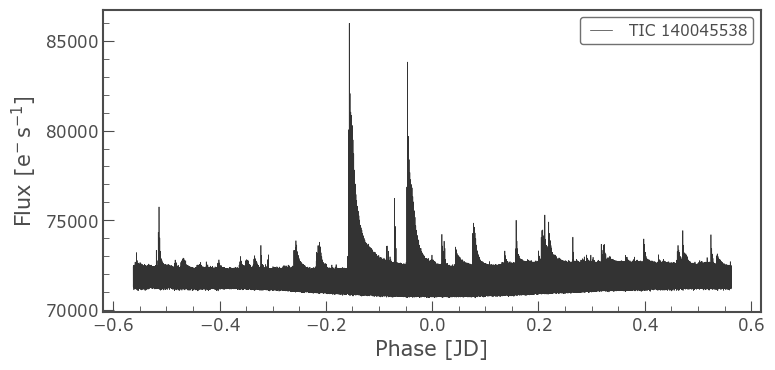

In [18]:
cd51lc.fold(P_rot.LS_results['avg_period_days'].data[0]).plot()


## Part 2: Using Stella

We will be using the flare finding algortithm developed by Adina Feinstein to search for flares in the TESS data.
You can learn more about stella and how it work here: https://adina.feinste.in/stella/index.html

We will start by creating a new folder in our local documents and downloading the training sets

In [19]:
import os, sys
#sys.path.insert(1,/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/stella/)
from tqdm import tqdm_notebook

In [20]:
ds = stella.DownloadSets()
ds.download_models()

Models have already been downloaded to ~/.stella/models


In [21]:
ds.models

array(['/Users/lupitatovar/.stella/models/hlsp_stella_tess_ensemblemodel_s004_tess_v0.1.0_cnn.h5',
       '/Users/lupitatovar/.stella/models/hlsp_stella_tess_ensemblemodel_s005_tess_v0.1.0_cnn.h5',
       '/Users/lupitatovar/.stella/models/hlsp_stella_tess_ensemblemodel_s018_tess_v0.1.0_cnn.h5',
       '/Users/lupitatovar/.stella/models/hlsp_stella_tess_ensemblemodel_s028_tess_v0.1.0_cnn.h5',
       '/Users/lupitatovar/.stella/models/hlsp_stella_tess_ensemblemodel_s029_tess_v0.1.0_cnn.h5',
       '/Users/lupitatovar/.stella/models/hlsp_stella_tess_ensemblemodel_s038_tess_v0.1.0_cnn.h5',
       '/Users/lupitatovar/.stella/models/hlsp_stella_tess_ensemblemodel_s050_tess_v0.1.0_cnn.h5',
       '/Users/lupitatovar/.stella/models/hlsp_stella_tess_ensemblemodel_s077_tess_v0.1.0_cnn.h5',
       '/Users/lupitatovar/.stella/models/hlsp_stella_tess_ensemblemodel_s078_tess_v0.1.0_cnn.h5',
       '/Users/lupitatovar/.stella/models/hlsp_stella_tess_ensemblemodel_s080_tess_v0.1.0_cnn.h5'],
      dty

Now we are going to create another folder where the results will be stored

In [22]:
OUT_DIR = '/Users/lupitatovar/local_flares/stella/results' #change this to you file path

Now we can call stella and tell it where we will be saving our results

In [23]:
cnn = stella.ConvNN(output_dir=OUT_DIR)

Can only use stella.ConvNN.predict().


Now we can use the model we saved to predict flares on the indicated light curve

In [24]:
cnn.predict(modelname=ds.models[0],
            times=cd51lc.time.btjd,
            fluxes=cd51lc.flux,
            errs=cd51lc.flux_err)
single_pred = cnn.predictions[0]

100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


You can inspect the model a bit more by calling cnn.model.summary() which details the layers, size, and output shapes for the 𝚜𝚝𝚎𝚕𝚕𝚊 models.

In [25]:
cnn.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           3136      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

Stella also makes some awesome plots that display and mark all of the flares that were identified in the light curve
The color bar tellls you how probable any given point(s) in time are to be flares (yellow = flare, purple = no flare)

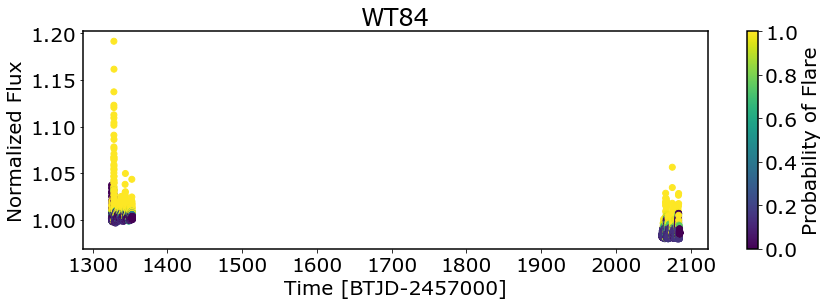

In [26]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BTJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('WT84');

### Ensembling 101

Averaging over multiple models provides a more robust classification. Although each model saw the same data, there is some randomness behind the scenes (e.g. the order the CNN sees each example). In that sense, if 10+ models agree on a given probability for a cadence, you can say with more confidence that it's a real flare. In that sense, averaging helps beat down false positives and provide more confidence in true positives.

In [27]:
preds = np.zeros((len(ds.models),len(cnn.predictions[0])))

for i, model in enumerate(ds.models):
    cnn.predict(modelname=ds.models[0],
                times=cd51lc.time.btjd,
                fluxes=cd51lc.flux,
                errs=cd51lc.flux_err)
    preds[i] = cnn.predictions[0]

avg_pred = np.nanmedian(preds, axis=0)

100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


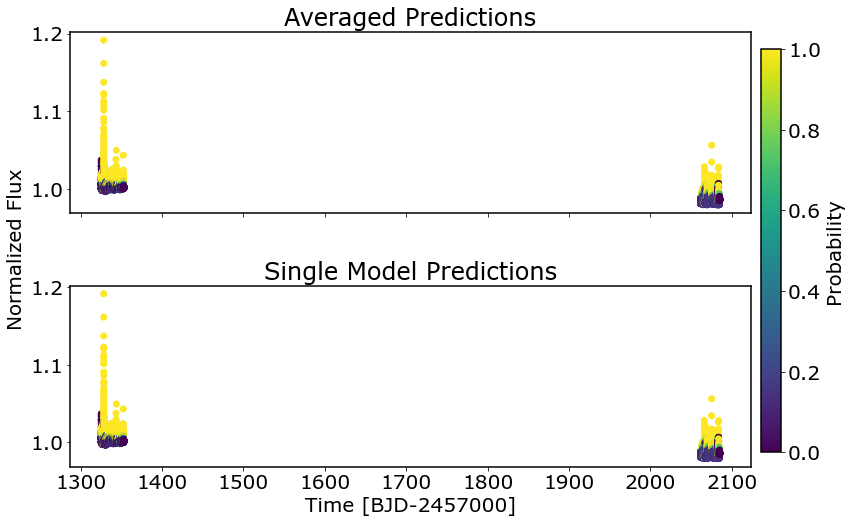

In [28]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True, sharey=True)
im = ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1)
ax2.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
ax2.set_xlabel('Time [BJD-2457000]')
ax2.set_ylabel('Normalized Flux', y=1.2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Probability')


ax1.set_title('Averaged Predictions')
ax2.set_title('Single Model Predictions')

plt.subplots_adjust(hspace=0.4);

Text(0.5, 1.0, 'Black = Single Model; Orange = Averaged Models')

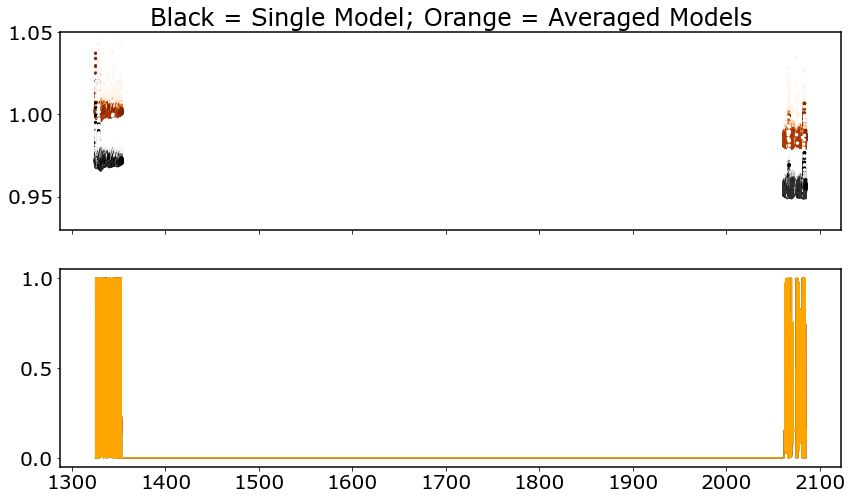

In [29]:
#zooming in to see differences
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, cmap='Oranges_r', s=6)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0]-0.03,
            c=single_pred, vmin=0, vmax=1, cmap='Greys_r', s=6)
ax1.set_ylim(0.93,1.05)
ax2.plot(cnn.predict_time[0], single_pred, 'k')
ax2.plot(cnn.predict_time[0], avg_pred, 'orange')

#ax2.set_xlim(1740,1745)
ax1.set_title('Black = Single Model; Orange = Averaged Models')

Fitting Flares

In [30]:
MODEL_DIR = '/Users/lupitatovar/.stella/models'
MODEL = [os.path.join(MODEL_DIR,i) for i in
          os.listdir(MODEL_DIR) if i.endswith('.h5')][0]

In [31]:
# fitting the flares
ff = stella.FitFlares(id=[target],
                      time=[cd51lc.time.btjd],
                      flux=[cd51lc.flux.value],
                      flux_err=[cd51lc.flux_err.value],
                      predictions=[cnn.predictions[0]])

In [33]:
ff.identify_flare_peaks(threshold=0.3) # can adjust threshold

ff.flare_table

Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
140045538.0,1329.478212613242,1.0025480093710821,2.5983581737147494,0.0030018312523459206,0.007995845197916915,0.5650001764297485
140045538.0,1329.478212613242,1.0025480093710821,2.5983581737147494,0.0030018312523459206,0.007995845197916915,0.5650001764297485
140045538.0,1330.7657192938418,1.004245915892885,4.292743795377942,0.0029754765433028583,0.007992363584183686,0.9887973666191101
140045538.0,1331.944890661751,1.0035247554812166,3.5733258452620045,0.002993910157906636,0.007996251353833545,0.6690959930419922
140045538.0,1331.944890661751,1.0035247554812166,3.5733258452620045,0.002993910157906636,0.007996251353833545,0.6690959930419922
140045538.0,1336.236562773246,1.00249222625936,2.527567912903519,0.0029953783879138143,0.007997964042115339,0.6624320149421692
140045538.0,1336.236562773246,1.00249222625936,2.527567912903519,0.0029953783879138143,0.007997964042115339,0.6624320149421692
140045538.0,1337.2546169843029,1.0022046577066022,2.2438880017489695,0.003,0.008,0.5438054800033569
140045538.0,1343.0948447685932,1.0039417567870061,3.998638926042968,0.0029924767734717146,0.007992710295330725,0.9841809868812561


In [34]:
flare_table = ff.flare_table
flare_table=flare_table.to_pandas()
flare_table = flare_table.drop_duplicates()
print(len(flare_table))

10


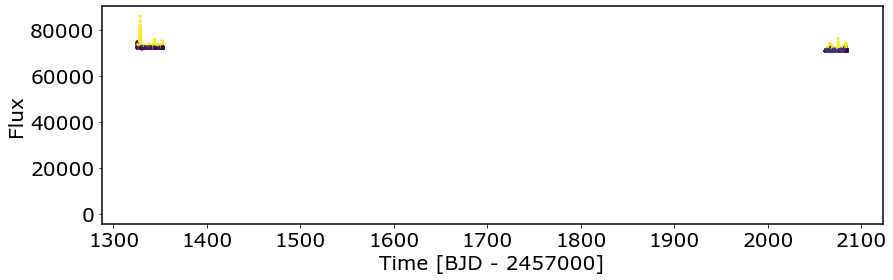

In [35]:
plt.figure(figsize=(14,4))
plt.scatter(ff.time[0], ff.flux[0], c=cnn.predictions[0], s=5)

for tpeak in ff.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)


plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Flux');
#plt.xlim(1738,1763)
#plt.ylim(109000,120000)

## Part 3: Flare Frequency Distributions

For this part we will be using code written by Dr. Jim Davenport (available on GitHub: https://github.com/jradavenport/FFD) to create a flare frequency distribution plot

In [39]:
from astropy.modeling.models import Gaussian2D


def FFD(ED, TOTEXP=1., Lum=30., fluxerr=0., dur=[], logY=True, est_comp=False):
    '''
    Given a set of stellar flares, with accompanying durations light curve properties,
    compute the reverse cumulative Flare Frequency Distribution (FFD), and
    approximate uncertainties in both energy and rate (X,Y) dimensions.
    This diagram can be read as measuring the number of flares per day at a
    given energy or larger.
    Not a complicated task, just tedious.
    Y-errors (rate) are computed using Poisson upper-limit approximation from
    Gehrels (1986) "Confidence limits for small numbers of events in astrophysical data", https://doi.org/10.1086/164079
    Eqn 7, assuming S=1.
    X-errors (event energy) are computed following Signal-to-Noise approach commonly
    used for Equivalent Widths in spectroscopy, from
    Vollmann & Eversberg (2006) "Astronomische Nachrichten, Vol.327, Issue 9, p.862", https://dx.doi.org/10.1002/asna.200610645
    Eqn 6.
    Parameters
    ----------
    ED : array of Equiv Dur's, need to include a luminosity!
    TOTEXP : total duration of observations, in days
    Lum : the log luminosity of the star
    fluxerr : the average flux errors of your data (in relative flux units!)
    dur : array of flare durations.
    logY : if True return Y-axis (and error) in log rate (Default: True)
    est_comp : estimate incompleteness using histogram method, scale Y errors?
        (Default: True)
    Returns
    -------
    ffd_x, ffd_y, ffd_xerr, ffd_yerr
    X coordinate always assumed to be log_10(Energy)
    Y coordinate is log_10(N/Day) by default, but optionally is N/Day
    Upgrade Ideas
    -------------
    - More graceful behavior if only an array of flares and a total duration are
        specified (i.e. just enough to make ffd_x, ffd_y)
    - Better propogation of specific flux errors in the light curve, rather than
        average error used
    - Include detrending errors? (e.g. from a GP)
    - Asymmetric Poisson errors?
    - Better handling of incompleteness?
    '''
    # REVERSE sort the flares in energy
    ss = np.argsort(np.array(ED))[::-1]
    ffd_x = np.log10(ED[ss]) + Lum

    Num = np.arange(1, len(ffd_x)+1)
    ffd_y = Num / TOTEXP

    # approximate the Poisson Y errors using Gehrels (1986) eqn 7
    Perror = np.sqrt(Num + 0.75) + 1.0
    ffd_yerr = Perror / TOTEXP

    # estimate completeness using the cumulative distribution of the histogram
    if est_comp:
        # make very loose guess at how many bins to choose
        nbin = int(np.sqrt(len(ffd_x)))
        if nbin < 10:
            nbin=10 # but use at least 10 bins

        # make histogram of the log(energies)
        hh, be = np.histogram(ffd_x, bins=nbin, range=[np.nanmin(ffd_x), np.nanmax(ffd_x)])
        hh = hh/np.nanmax(hh)
        # make cumulative distribution of the histogram, scale to =1 at the hist peak
        cc = np.cumsum(hh)/np.sum(hh[0:np.argmax(hh)])
        be = (be[1:]+be[0:-1])/2
        # make completeness = 1 for energies above the histogram peak
        cc[np.argmax(hh):] = 1
        # interpolate the cumulative histogram curve back to the original energies
        ycomp = np.interp(ffd_x, be, cc)
        # scale the y-errors by the completeness factor (i.e. inflate small energy errors)
        ffd_yerr = ffd_yerr / ycomp

    if logY:
        # transform FFD Y and Y Error into log10
        ffd_yerr = np.abs(ffd_yerr / np.log(10.) / ffd_y)
        ffd_y = np.log10(ffd_y)

    # compute X uncertainties for FFD
    if len(dur)==len(ffd_x):

        # assume relative flux error = 1/SN
        S2N = 1/fluxerr
        # based on Equivalent Width error
        # Eqn 6, Vollmann & Eversberg (2006) Astronomische Nachrichten, Vol.327, Issue 9, p.862
        ED_err = np.sqrt(2)*(dur[ss]*86400. - ED[ss])/S2N
        ffd_xerr = np.abs((ED_err) / np.log(10.) / ED[ss]) # convert to log
    else:
        # not particularly meaningful, but an interesting shape. NOT reccomended
        print('Warning: Durations not set. Making bad assumptions about the FFD X Error!')
        #ffd_xerr = (1/np.sqrt(ffd_x-np.nanmin(xT))/(np.nanmax(ffd_x)-np.nanmin(ffd_x)))
#what is xT?? should it be ffd_x??
        ffd_xerr = (1/np.sqrt(ffd_x-np.nanmin(ffd_x))/(np.nanmax(ffd_x)-np.nanmin(ffd_x)))
    return ffd_x, ffd_y, ffd_xerr, ffd_yerr


def FlareKernel(x, y, xe, ye, Nx=100, Ny=100, xlim=[], ylim=[], return_axis=True):
    '''
    Use 2D Gaussians (from astropy models) to make a basic kernel density,
    with errors in both X and Y considered. Turn into a 2D "image"
    Upgrade Ideas
    -------------
    It's slow. Since Gaussians are defined analytically, maybe this could be
    re-cast as a single array math opperation, and then refactored to have the
    same fit/evaluate behavior as KDE functions.  Hmm...
    '''

    if len(xlim) == 0:
        xlim = [np.nanmin(x) - np.nanmean(xe), np.nanmax(x) + np.nanmean(xe)]
    if len(ylim) == 0:
        ylim = [np.nanmin(y) - np.nanmean(ye), np.nanmax(y) + np.nanmean(ye)]

    xx,yy = np.meshgrid(np.linspace(xlim[0], xlim[1], Nx),
                        np.linspace(ylim[0], ylim[1], Ny), indexing='xy')
    dx = (np.max(xlim)-np.min(xlim)) / (Nx-1)
    dy = (np.max(ylim)-np.min(ylim)) / (Ny-1)

    im = np.zeros_like(xx)

    for k in range(len(x)):
        g = Gaussian2D(amplitude=1/(2*np.pi*(xe[k]+dx)*(ye[k]+dy)),
                       x_mean=x[k], y_mean=y[k], x_stddev=xe[k]+dx, y_stddev=ye[k]+dy)
        tmp = g(xx,yy)
        if np.isfinite(np.sum(tmp)):
            im = im + tmp

    if return_axis:
        return im, xx, yy
    else:
        return im

### Defining the variables we need to create an ffd
Flare frequency distribution diagrams tell us about the occurence rate of flares on stars as a function of flare energy.

How many flares of a certain energy are happening per day

x-axis : log (energy of flares) units erg

y-axis: # of flares (days)

In [40]:
flare_table

,Target_ID,tpeak,amp,ed_s,rise,fall,prob
0,154101678.0,1744.141076,1.003391,3.451059,0.003000,0.008000,0.467328
1,154101678.0,1744.509136,1.004036,4.134523,0.002988,0.007998,0.986428
3,154101678.0,1745.067474,1.002121,2.159797,0.003000,0.008000,0.447946
4,154101678.0,1747.038326,1.004147,4.209362,0.002990,0.007999,0.723079
5,154101678.0,1752.864760,1.005873,5.978166,0.003000,0.008000,0.758310
7,154101678.0,1753.349483,1.005977,6.102878,0.003015,0.008009,0.999927
8,154101678.0,1753.580038,1.007211,7.333969,0.002988,0.008007,0.999594
10,154101678.0,1755.749479,1.004040,4.098575,0.002995,0.007996,0.390640
12,154101678.0,1755.873090,1.002735,2.783211,0.003000,0.008000,0.843271
13,154101678.0,1757.228640,1.005175,5.250226,0.002986,0.007996,0.952772


In [41]:
flare_table['ed_s'].values

array([3.45105883, 4.13452313, 2.1597974 , 4.20936211, 5.97816555,
       6.10287816, 7.33396861, 4.09857453, 2.78321093, 5.25022626,
       7.81789826])

In [42]:
np.argsort(flare_table['ed_s'].values)[::-1]

array([10,  6,  5,  4,  9,  3,  1,  7,  0,  8,  2])

In [36]:
Lo= 32 #30.352907
tess_sort = np.argsort(flare_table['ed_s'].values)[::-1]
ED = flare_table['ed_s'].values[tess_sort] #reverse sorted equivalent duration values 
time = np.nanmedian(np.diff(cd51lc.time.btjd)) * (len(cd51lc.time.btjd)) #number of days of data you have for given star from TESS
nu = (np.arange(1, len(ED)+1)) / time


In [64]:
nu

array([0.01098613, 0.02197227, 0.0329584 , 0.04394453, 0.05493067,
       0.0659168 , 0.07690293, 0.08788907, 0.0988752 ])

In [37]:
tess_x = np.log10(ED) + (Lo)
tess_y = np.log10(nu)

In [66]:
tess_x

array([31.19561874, 31.08198181, 30.91256211, 30.86972703, 30.71311212,
       30.61898616, 30.4413755 , 30.39531272, 30.31651632])

In [67]:
tess_y

array([-1.95915513, -1.65812513, -1.48203387, -1.35709514, -1.26018512,
       -1.18100388, -1.11405709, -1.05606514, -1.00491262])

In [38]:
plt.rcParams['axes.linewidth']=1.5
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ['Verdana']

Text(0, 0.5, '# of Flares [day$^{-1}$]')

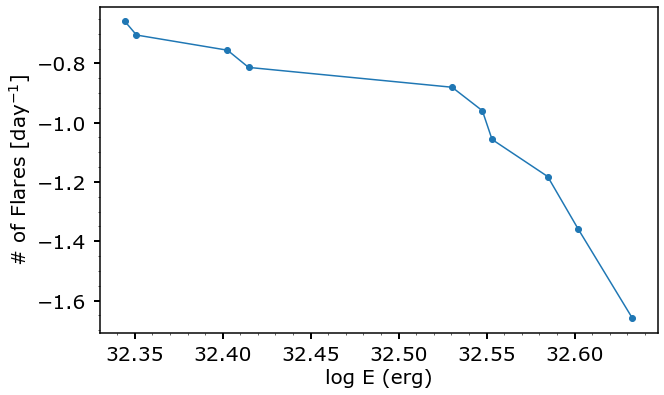

In [39]:
#Making the plot look nicer
plt.figure(figsize=[10,6])
plt.minorticks_on()
plt.tick_params(direction='out',width=2,length=6,pad=7)


#Plotting the FFD
plt.plot(tess_x,tess_y,'-o')
plt.xlabel('log E (erg)')
#plt.ylabel(r'log $\nu$ (day$^{-1}$)')
plt.ylabel('# of Flares [day$^{-1}$]')

Saving the FFD arrays to a text file:

Step 1: save the arrays to a table

step 2: save the table to a file on your computer

In [50]:
data= {'log_E': tess_x, 'Freq': tess_y}
df = pd.DataFrame(data=data)

In [51]:
df

,log_E,Freq
0,31.245997,-1.293365
1,31.218246,-0.992335
2,31.138442,-0.816243
3,31.129475,-0.691305
4,31.073085,-0.594395
5,30.977123,-0.515213
6,30.969332,-0.448267
7,30.965540,-0.390275
8,30.890859,-0.339122
9,30.797453,-0.293365


The line below saves the table to a file, each time you run this cell things will overwrite so only run it once and then comment it out!

In [52]:
#This saves the table to a .csv file on your computer
#df.to_csv('ev_lac2.csv') 

Reading in the file

In [40]:
AU_mic=pd.read_csv('AU_Mic.csv')
AT_mic =pd.read_csv('AT_mic.csv')

In [41]:
gj1243=pd.read_csv('gj1243_tess_ffd.csv')

Push your table to github and/or email it to one another so we can all have access to the data

Now import in the file(s) from each other and make a new FFD figure that includes data from multiple stars (add a legend so we know which is which and save this figure)

In [55]:
# reading in the ffd file


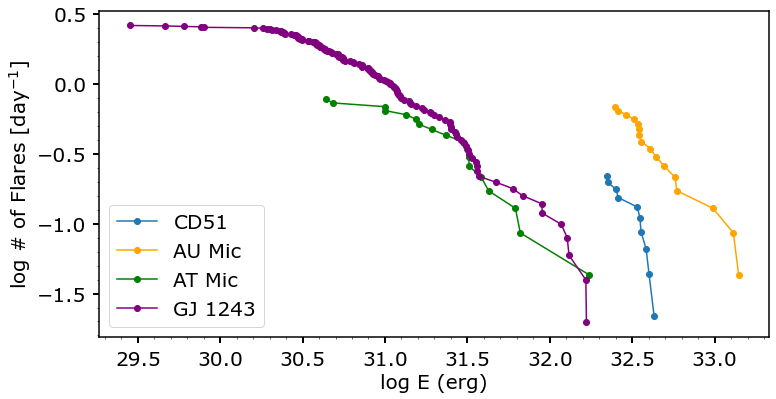

In [43]:
#Making the plot look nicer
plt.figure(figsize=[12,6])
plt.minorticks_on()
plt.tick_params(direction='out',width=2,length=6,pad=7)


#Plotting the FFD
plt.plot(tess_x,tess_y,'-o',color='C0',label='CD51')
plt.plot(AU_mic['log_E'].values,AU_mic['Freq'].values,'-o',color='orange',label='AU Mic')
plt.plot(AT_mic['log_E'].values+0.3,AT_mic['Freq'].values,'-o',color='green',label='AT Mic')
plt.plot(gj1243['log_E'].values,gj1243['Freq'].values,'-o',color='purple',label='GJ 1243')
plt.xlabel('log E (erg)')
#plt.ylabel(r'log $\nu$ (day$^{-1}$)')
plt.ylabel('log # of Flares [day$^{-1}$]')
plt.legend()#bbox_to_anchor=(1, .96))

In [62]:
#Factor to double luminosity for AT Mic since its a binary
np.log10(2)

0.3010299956639812

Congrats on getting this far! The next steps will be to perform this analyis on new stars and then add the resulting FFD to the final plot so we can compare all of the stars